In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost

# Data Preprocessing
Data Split, Train-test Split, etc...

In [14]:
#Import Data

data = pd.read_excel(r'/Users/familiadelasherasgarciahijosdanielnuriapablo/Documents/Applied Math and Data Science/Jovia/DeidentifiedSDOHPatientData-v1.xlsx')

data.columns = ['id', 'age', 'race', 'ethnicity', 'gender',
       'Q1',
       'Q2',
       'Q3',
       'Q4',
       'Q5',
       'Q6',
       'Q7',
       'Q8']

# Only get the first three columns - predictor, and only question column - label
data = data[['age', 'race', 'ethnicity', 'gender',
       'Q1']]

# Drop Patient declined, Patient unable to answer
target_rows     = (data['Q1']=='Patient declined')| (data['Q1']=='Patient unable to answer') | (data['Q1'].isnull())

future_predict  = data[target_rows]

future_predict.drop(columns = ['Q1'], inplace = True)

data       = data[~target_rows]

/var/folders/g3/ncfg5yhn47v7z7k0wmn723zc0000gn/T/ipykernel_21983/3433434604.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_predict.drop(columns = ['Q1'], inplace = True)


In [15]:
# One Hot Encoding
dummies = pd.get_dummies(data[['race', 'ethnicity', 'gender']], drop_first=True, dtype=float)

data.drop(columns = ['race', 'ethnicity', 'gender'], inplace =True)

data = pd.concat([data, dummies], axis = 1)

,age,Q1,"race_ American Indian or Alaska Native, Black or African American","race_ American Indian or Alaska Native, Black or African American, Filipino","race_ American Indian or Alaska Native, Black or African American, Other","race_ American Indian or Alaska Native, White or Caucasian",race_ Asian Indian,"race_ Asian Indian, Other","race_ Asian Indian, Unknown","race_ Asian Indian, White or Caucasian",...,"race_ White or Caucasian, Other","race_ White or Caucasian, Other Asian","race_ White or Caucasian, Unknown",ethnicity_Hispanic or Latino,"ethnicity_Mexican, Mexican American, Chicano/a",ethnicity_Not Hispanic or Latino,ethnicity_Patient Refused,ethnicity_Puerto Rican,ethnicity_Unknown,gender_Male
0,68,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,77,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,71,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,80,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,83,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15837,95,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15839,94,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15840,75,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15841,82,Never True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
X = data.drop(columns = 'Q1')
y = data['Q1']

# Label Encoding
mapping = {'Never True':0,
       'Sometimes True':1, 'Often True':1}

reverse_mapping = {0:'False', 1:'True'}

y = y.map(mapping)

In [44]:
from sklearn.model_selection import train_test_split

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0, stratify=y)

In [45]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smt_train, y_smt_train = oversample.fit_resample(X_train, y_train)

In [59]:
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred):
    recall_label_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_label_1 = recall_score(y_true, y_pred, pos_label=1)
    precision_label_0 = precision_score(y_true, y_pred, pos_label=0)
    precision_label_1 = precision_score(y_true, y_pred, pos_label=1)
    weighted_recall = 1 * recall_label_1 + 0 * recall_label_0 +   0 * precision_label_0 + 0 * precision_label_1# Weighted average with more weight on label 1
    return weighted_recall
scorer = make_scorer(custom_scorer)

In [77]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params={
 "scale_pos_weight" : [{0:1,1:1},{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

model = xgboost.XGBClassifier()

random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring=scorer,n_jobs=-1,cv=5,verbose=3)

random_search.fit(X_train,y_train)

random_search.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.000 total time=   0.1s


/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.25, max_depth=5, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.25, max_depth=5, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.25, max_depth=5,

/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/familiadelasherasgarciahijosdanielnuriapablo/anaconda3/envs/MTH695/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1;, score=0.000 total time=   0.1s


{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.15,
 'gamma': 0.4,
 'colsample_bytree': 0.3}

## XGBoost

In [69]:
xgb = xgboost.XGBClassifier(min_child_weight= 5,
 max_depth= 6,
 learning_rate= 0.05,
 gamma= 0.1,
 colsample_bytree= 0.5)
xgb.fit(X_smt_train,y_smt_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
y_pred = xgb.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.9613059250302297


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4074
           1       0.05      0.10      0.07        61

    accuracy                           0.96      4135
   macro avg       0.52      0.54      0.53      4135
weighted avg       0.97      0.96      0.97      4135



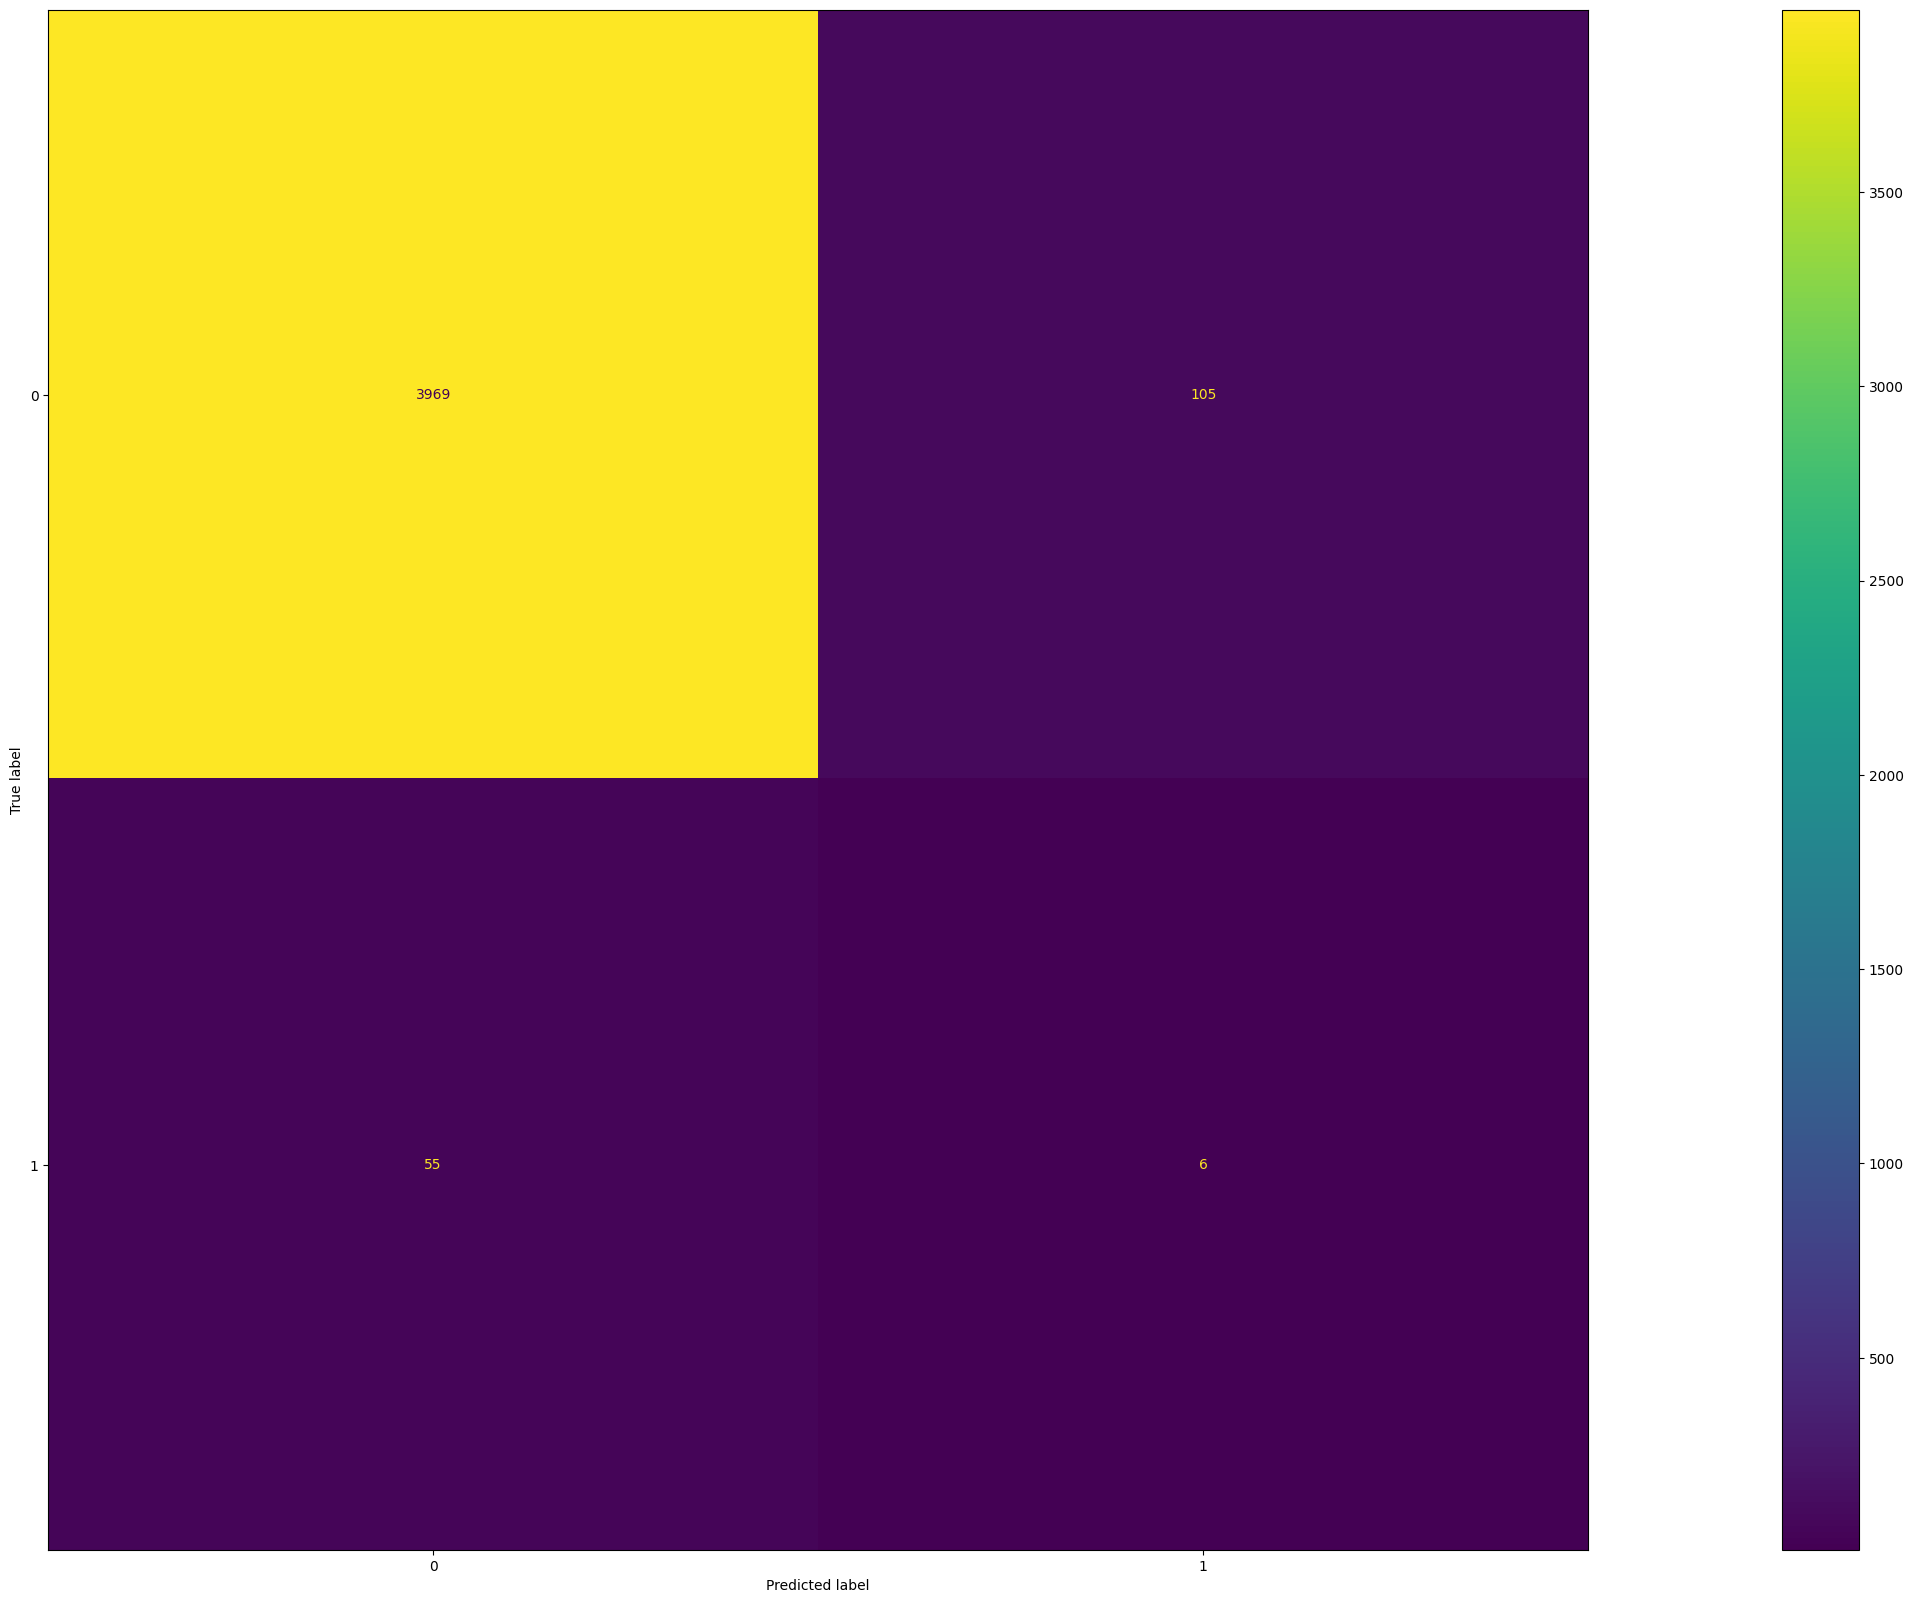

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
dist= ConfusionMatrixDisplay(cm)
dist.plot()